In [36]:
import re
import pandas as pd

import numpy as np
from datasets import load_dataset

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed

set_seed(42)

In [9]:
def create_sentence_pairs(x, tokenizer):
    sentences = re.split(r'[\s]*#Person\d#: ', x['dialogue'])[1:]
    return {
        'sentence_pairs': [' '.join([tokenizer.bos_token, sent1, tokenizer.pad_token, sent2, tokenizer.eos_token]) for
                           sent1, sent2 in zip(sentences[:-1], sentences[1:])]}

def prepare_model_and_tokenizer(path, device):
    # get gpt2 tokenizer and add special tokens
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens(
        {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'unk_token': '<UNK>', 'pad_token': '<PAD>'})

    # get gpt2 model and resize the output shape based on the tokens added
    model = AutoModelForCausalLM.from_pretrained(path)
    model.resize_token_embeddings(len(tokenizer))

    return model.to(device), tokenizer


In [4]:
class GPTDataset(Dataset):
    def __init__(self, sentence_pairs, tokenizer, max_len, device):
        flatten_tokens = [sent for sents in sentence_pairs for sent in sents]
        flatten_tokens = pd.DataFrame(flatten_tokens).drop_duplicates()[0].tolist()
        
        self.tokenized_pairs = tokenizer(flatten_tokens, max_length=max_len, padding='max_length', 
                                         truncation=True, return_tensors='pt')
        self.tokenized_inputs = self.tokenized_pairs['input_ids']
        self.tokenized_mask = self.tokenized_pairs['attention_mask']

        self.device = device

    def __getitem__(self, item):
        return {'input_ids': self.tokenized_inputs[item].to(self.device),
                'attention_mask': self.tokenized_mask[item].to(self.device)}

    def __len__(self):
        return len(self.tokenized_inputs)


In [28]:
def train_step(model, optimizer, train_loader):
    model.train()

    train_losses = []
    pbar = tqdm(train_loader)
    for idx, x in enumerate(pbar):
        optimizer.zero_grad()
        loss = model(**x, labels=x['input_ids']).loss
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_description(f'Loss: {np.mean(train_losses):.3f}')

    return np.mean(train_losses)

def eval_step(model, val_loader):
    model.eval()

    val_losses = []
    pbar = tqdm(val_loader)
    with torch.no_grad():
        for x in pbar:
            loss = model(**x, labels=x['input_ids']).loss
            val_losses.append(loss.item())
            pbar.set_description(f'Validation Loss: {np.mean(val_losses):.3f}')

    return np.mean(val_losses)


In [6]:
def train(max_len, epochs, bs, lr, device):
    model_path = 'gpt2'
    model, tokenizer = prepare_model_and_tokenizer(model_path, device)

    train_dataset = load_dataset('knkarthick/dialogsum', split='train')
    val_dataset = load_dataset('knkarthick/dialogsum', split='validation')

    train_dataset = train_dataset.map(lambda x: create_sentence_pairs(x, tokenizer))
    val_dataset = val_dataset.map(lambda x: create_sentence_pairs(x, tokenizer))

    gpt_train = GPTDataset(train_dataset['sentence_pairs'], tokenizer, max_len, device)
    gpt_valid = GPTDataset(val_dataset['sentence_pairs'], tokenizer, max_len, device)

    train_loader = DataLoader(gpt_train, batch_size=bs, shuffle=True)
    val_loader = DataLoader(gpt_valid, batch_size=bs, shuffle=True)

    optimizer = Adam(model.parameters(), lr=lr)

    df = pd.DataFrame(columns=['Training Loss', 'Validation Loss'])
    
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        train_loss = train_step(model, optimizer, train_loader)
        val_loss = eval_step(model, val_loader)

        df.at[epoch, 'Training Loss'] = train_loss
        df.at[epoch, 'Validation Loss'] = val_loss
        
    return df, model

In [22]:
model_path = '/kaggle/working/gpt_model_1e-05_1'
max_len = 100
bs = 4
lr = 1e-5
device = 'cuda'

In [40]:
model, tokenizer = prepare_model_and_tokenizer(model_path, device)

train_dataset = load_dataset('knkarthick/dialogsum', split='train')
val_dataset = load_dataset('knkarthick/dialogsum', split='validation')

train_dataset = train_dataset.map(lambda x: create_sentence_pairs(x, tokenizer))
val_dataset = val_dataset.map(lambda x: create_sentence_pairs(x, tokenizer))

gpt_train = GPTDataset(train_dataset['sentence_pairs'], tokenizer, max_len, device)
gpt_valid = GPTDataset(val_dataset['sentence_pairs'], tokenizer, max_len, device)

train_loader = DataLoader(gpt_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(gpt_valid, batch_size=bs)

optimizer = Adam(model.parameters(), lr=lr)

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

In [41]:
df = pd.DataFrame(columns=['Training Loss', 'Validation Loss'])

for epoch in range(5):
    train_loss = train_step(model, optimizer, train_loader)
    val_loss = eval_step(model, val_loader)

    df.at[epoch, 'Training Loss'] = train_loss
    df.at[epoch, 'Validation Loss'] = val_loss
    
    model.save_pretrained(f'gpt_epoch_{epoch}')


  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

In [2]:
df

NameError: name 'df' is not defined

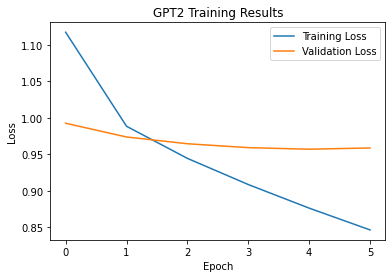

In [51]:
import matplotlib.pyplot as plt
pd.DataFrame({'Training Loss': [1.117637, 0.988489, 0.944406, 0.908475, 0.876072, 0.846153],
              'Validation Loss': [0.992663, 0.973782, 0.964497, 0.959157, 0.956979, 0.958734]}).plot()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GPT2 Training Results')
plt.savefig('gpt2_plot')

In [12]:
for lr in [1e-3, 1e-5]:
    for t in range(3):
        df, model = train(max_len=100, epochs=1, device='cuda', lr=lr, bs=4)
        print(df)
        
        model.save_pretrained(f'gpt_model_{lr}_{t}')


  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  Training Loss Validation Loss
0      1.248618        1.184095


  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  Training Loss Validation Loss
0      1.235748        1.184453


  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  Training Loss Validation Loss
0      1.239397        1.184788


  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  Training Loss Validation Loss
0      1.138026        0.993942


  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  Training Loss Validation Loss
0      1.117637        0.992663


  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

  Training Loss Validation Loss
0      1.116082        0.992898


In [20]:
ls = [1.02652, 1.02342, 1.01925]
np.mean(ls), np.std(ls)

(1.0230633333333334, 0.002978661145921516)

In [4]:
!zip -r gpt_4.zip /kaggle/working/gpt_epoch_4/

  adding: kaggle/working/gpt_epoch_4/ (stored 0%)
  adding: kaggle/working/gpt_epoch_4/config.json (deflated 51%)
  adding: kaggle/working/gpt_epoch_4/pytorch_model.bin (deflated 9%)


In [ ]:
while True:
    pass